In [73]:
from pprint import pprint
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import requests
from bs4 import BeautifulSoup as bs
import xml.etree.ElementTree as ET
%matplotlib inline
style.use('fivethirtyeight')

## Load XML data

In [3]:
url_root = 'https://www.usada.org/uploads/web_hist_files/xml/'
years = list(range(2015,2019))

urls = [url_root + str(yr) + 'all.xml' for yr in years]
yr_bytes = [requests.get(u).content for u in urls]

In [4]:
print(urls)

['https://www.usada.org/uploads/web_hist_files/xml/2015all.xml', 'https://www.usada.org/uploads/web_hist_files/xml/2016all.xml', 'https://www.usada.org/uploads/web_hist_files/xml/2017all.xml', 'https://www.usada.org/uploads/web_hist_files/xml/2018all.xml']


In [5]:
for y in yr_bytes:
    print(y[:200])
    print('\n\n')

b'<TestHistory><TREC><YR>2015</YR><QTR>All</QTR><AName>Madeline Aaron</AName><NumTests>2</NumTests><Sport>Figure Skating</Sport><AFN>Madeline</AFN><ALN>Aaron</ALN></TREC><TREC><YR>2015</YR><QTR>All</QTR'



b'\xff\xfe<\x00T\x00e\x00s\x00t\x00H\x00i\x00s\x00t\x00o\x00r\x00y\x00>\x00<\x00T\x00R\x00E\x00C\x00>\x00<\x00Y\x00R\x00>\x002\x000\x001\x006\x00<\x00/\x00Y\x00R\x00>\x00<\x00Q\x00T\x00R\x00>\x00A\x00l\x00l\x00<\x00/\x00Q\x00T\x00R\x00>\x00<\x00A\x00N\x00a\x00m\x00e\x00>\x00J\x00e\x00s\x00s\x00i\x00c\x00a\x00 \x00(\x00P\x00i\x00x\x00l\x00e\x00r\x00)\x00 \x00T\x00e\x00b\x00o\x00<\x00/\x00A\x00N\x00a\x00m\x00e\x00>\x00<\x00N\x00u\x00m\x00T\x00e\x00s\x00t\x00s\x00>\x001\x00<\x00/\x00N\x00u\x00m\x00T\x00'



b'\xff\xfe<\x00T\x00e\x00s\x00t\x00H\x00i\x00s\x00t\x00o\x00r\x00y\x00>\x00<\x00T\x00R\x00E\x00C\x00>\x00<\x00Y\x00R\x00>\x002\x000\x001\x007\x00<\x00/\x00Y\x00R\x00>\x00<\x00Q\x00T\x00R\x00>\x00A\x00l\x00l\x00<\x00/\x00Q\x00T\x00R\x00>\x00<\x00A\x00N\x00a\x00m\x00e\x00>\x00M\x00a\x

## Parsing XML to DF

In [6]:
roots = {}
athletes = {}
dfs = {}

# Create dict of xml root elements for each year. 
for i, y in enumerate(years):
    roots[y] = ET.fromstring(yr_bytes[i])
    athletes[y] = []
    
    # Filter by sport to create list of athlete dicts for each year.
    for child in roots[y]:
        player_dict = {
            'year': child[0].text,
            'sport': child[4].text,
            'fname': child[5].text,
            'lname': child[6].text,
            'tests': child[3].text
        }
        athletes[y].append(player_dict)
        
    # Create dataframe for each year
    dfs[y] = pd.DataFrame(athletes[y])
    dfs[y] = dfs[y].astype({'tests': 'int64', 'year': 'int64'})

In [8]:
for df in dfs.values():
    print(df.head(), '\n')

      fname    lname              sport  tests  year
0  Madeline    Aaron     Figure Skating      2  2015
1       Max    Aaron     Figure Skating      3  2015
2   Stephen     Abas          Wrestling      1  2015
3     Mason  Abbiate  Paralympic Soccer      1  2015
4    Jeremy   Abbott     Figure Skating      1  2015 

      fname          lname              sport  tests  year
0   Jessica  (Pixler) Tebo    Track and Field      1  2016
1  Madeline          Aaron     Figure Skating      1  2016
2       Max          Aaron     Figure Skating      2  2016
3     Mason        Abbiate  Paralympic Soccer      1  2016
4      Mara         Abbott            Cycling      8  2016 

       fname         lname                 sport  tests  year
0        Max         Aaron        Figure Skating      3  2017
1       Mara        Abbott               Cycling      5  2017
2     Taylor        Abbott              Swimming      2  2017
3  Abdihakim    Abdirahman       Track and Field     10  2017
4     Hakeem  

In [9]:
for d in dfs.values():
    print(d.loc[d.sport == 'Mixed Martial Arts', :].sort_values('tests', ascending=False).head(10), '\n')
    print(d.loc[d.sport == 'Mixed Martial Arts', :].sort_values('tests', ascending=True).head(10), '\n\n')

        fname      lname               sport  tests  year
2564    Ronda     Rousey  Mixed Martial Arts      8  2015
29       Jose       Aldo  Mixed Martial Arts      8  2015
1990    Conor   McGregor  Mixed Martial Arts      8  2015
1282      Dan  Henderson  Mixed Martial Arts      7  2015
1371    Holly       Holm  Mixed Martial Arts      7  2015
647   Antonio   Da Silva  Mixed Martial Arts      7  2015
2536     Yoel     Romero  Mixed Martial Arts      6  2015
2509     Luke   Rockhold  Mixed Martial Arts      6  2015
774    Rafael  Dos Anjos  Mixed Martial Arts      6  2015
184     Vitor    Belfort  Mixed Martial Arts      6  2015 

       fname      lname               sport  tests  year
24     Omari   Akhmedov  Mixed Martial Arts      1  2015
2169     Roy     Nelson  Mixed Martial Arts      1  2015
2121  Gegard    Mousasi  Mixed Martial Arts      1  2015
2083  Takeya   Mizugaki  Mixed Martial Arts      1  2015
1967  Tamdan    McCrory  Mixed Martial Arts      1  2015
1931   Jorge   Mas

In [55]:
# Filter to mma only and combine into 1 df
mma = pd.concat([df.loc[df.sport=='Mixed Martial Arts',:] for df in dfs.values()], axis=0)\
    .drop('sport', axis=1)
sports = pd.concat([df.loc[df.sport!='Mixed Martial Arts',:] for df in dfs.values()], axis=0)

In [56]:
def partial_year_percent(cell):
    '''Calculate % of year under USADA since some are <365 (first year of program
    and current year in progress).'''
    if cell == 2015:
        years = (datetime.date(2016, 1, 1) - start_date).days / 365
    elif cell == end_date.year:
        years = (end_date - datetime.date(end_date.year-1, 12, 31)).days / 365
    else:
        years = 1
    return years

In [57]:
start_date = datetime.date(2015, 7, 1)
end_date = datetime.date.today()
mma['year_percent'] = mma['year'].apply(partial_year_percent)

In [58]:
mma['req_tests'] = np.maximum(mma['tests'] - 2, 0)
mma['scaled_tests'] = mma['tests'] / mma['year_percent']
mma['scaled_req_tests'] = np.maximum(mma['scaled_tests'] - 2, 0)

In [59]:
print(mma.head())
print(sports.head())

     fname     lname  tests  year  year_percent  req_tests  scaled_tests  \
24   Omari  Akhmedov      1  2015       0.50411          0      1.983696   
29    Jose      Aldo      8  2015       0.50411          6     15.869565   
41   Eddie   Alvarez      2  2015       0.50411          0      3.967391   
44  Thiago     Alves      5  2015       0.50411          3      9.918478   
50   Corey  Anderson      1  2015       0.50411          0      1.983696   

    scaled_req_tests  
24          0.000000  
29         13.869565  
41          1.967391  
44          7.918478  
50          0.000000  
      fname    lname              sport  tests  year
0  Madeline    Aaron     Figure Skating      2  2015
1       Max    Aaron     Figure Skating      3  2015
2   Stephen     Abas          Wrestling      1  2015
3     Mason  Abbiate  Paralympic Soccer      1  2015
4    Jeremy   Abbott     Figure Skating      1  2015


In [271]:
fighter_totals = mma['tests'].groupby([mma.lname, mma.fname]).sum().sort_values(ascending=False)

print(fighter_totals.head(10))
print(fighter_totals.tail(10))

lname      fname    
Holm       Holly        35
Romero     Yoel         35
Dos Anjos  Rafael       34
Belfort    Vitor        33
Justino    Cristiane    33
Cormier    Daniel       32
Alvarez    Eddie        32
Cruz       Dominick     29
McGregor   Conor        28
Lawler     Robbie       28
Name: tests, dtype: int64
lname             fname   
Bessette          Matthew     1
Nakai             Rin         1
Hu                Yaozong     1
Pingyuan          Liu         1
Gallicchio        Tom         1
Simon             Ricky       1
Nasrat Haqparast  Mohammad    1
Holohan           Patrick     1
Sims              Tony        1
Dempsey           Chris       1
Name: tests, dtype: int64


In [66]:
grouped_avg = mma[['tests', 'scaled_tests', 'req_tests', 'scaled_req_tests']].groupby(mma.year)\
    .agg([np.mean, np.sum, len])
grouped_avg

tests            scaled_tests                     req_tests        \
          mean   sum  len         mean          sum    len      mean   sum   
year                                                                         
2015  2.262821   353  156     4.488747   700.244565  156.0  0.730769   114   
2016  3.907850  2290  586     3.907850  2290.000000  586.0  2.076792  1217   
2017  4.524880  2819  623     4.524880  2819.000000  623.0  2.653291  1653   
2018  2.060329  1127  547     4.820642  2636.891026  547.0  0.433272   237   

          scaled_req_tests                      
      len             mean          sum    len  
year                                            
2015  156         2.496377   389.434783  156.0  
2016  586         2.076792  1217.000000  586.0  
2017  623         2.653291  1653.000000  623.0  
2018  547         2.820642  1542.891026  547.0

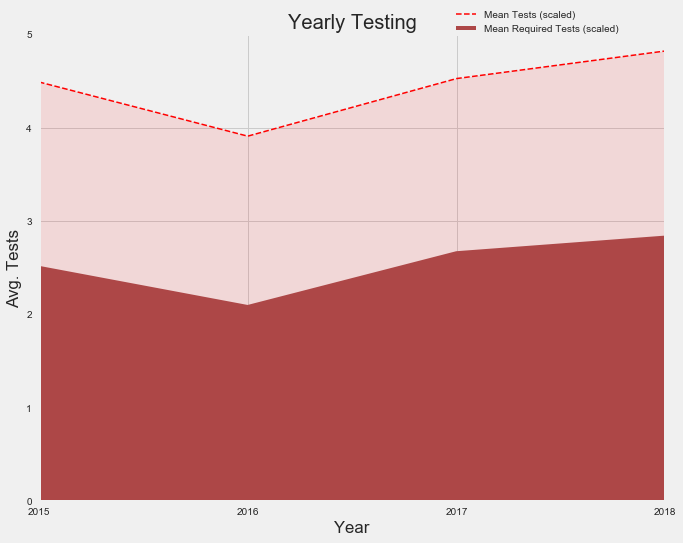

In [189]:
scaled_means = grouped_avg['scaled_tests']['mean'].values
scaled_req_means = grouped_avg['scaled_req_tests']['mean'].values

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(years, scaled_means, color='red', ls='--', lw=1.5, label='Mean Tests (scaled)')
ax.plot(years, scaled_req_means, color='#ad4747', label='Mean Required Tests (scaled)')
ax.fill_between(years, scaled_means, scaled_req_means, alpha=0.1, color='red')
ax.fill_between(years, scaled_req_means, 0, color='#ad4747')
plt.xlim(start_date.year, end_date.year)
plt.xticks(years)
plt.xlabel('Year')
plt.ylim(0, 5)
plt.ylabel('Avg. Tests')
plt.title('Yearly Testing')
plt.legend(loc='upper right', bbox_to_anchor=(.94, 1.07))
plt.show()

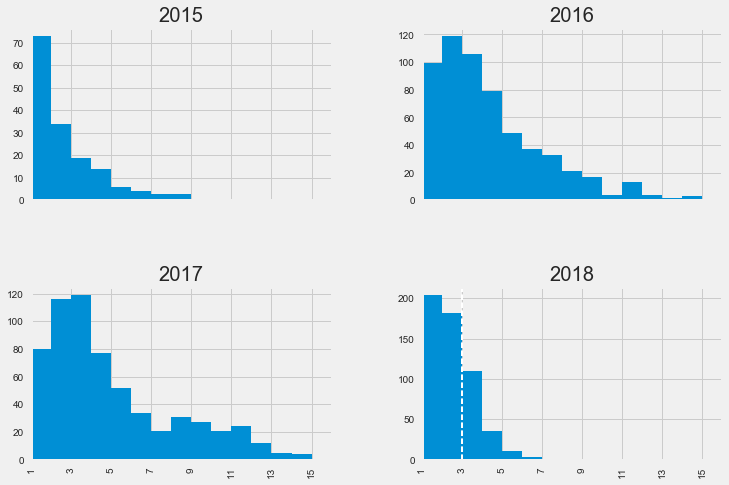

In [260]:
mma.hist('tests', by='year', figsize=(12,8), sharex=True, bins=range(16))
plt.axvline(3, ls='--', lw=2, color='white')
plt.xticks(range(1, 17, 2))
plt.xlim(1, 16)
plt.show()

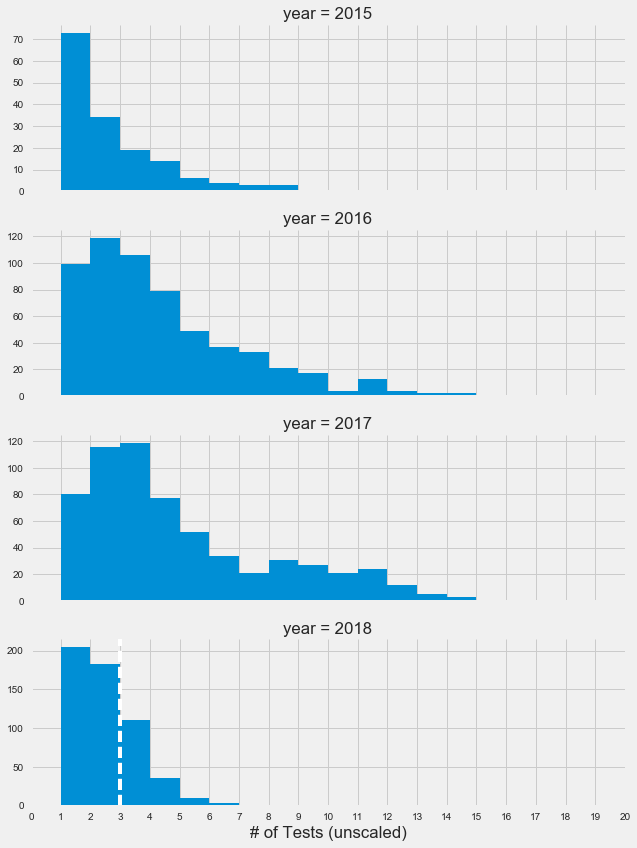

In [228]:
g = sns.FacetGrid(mma, row='year', size=3, aspect=3, sharex=True, sharey=False)
g = g.map(plt.hist, 'tests', bins=range(21))
plt.xlim(0, 20)
plt.xticks(range(21))
plt.xlabel('# of Tests (unscaled)')
plt.axvline(3, ls='--', color='white')
plt.show()

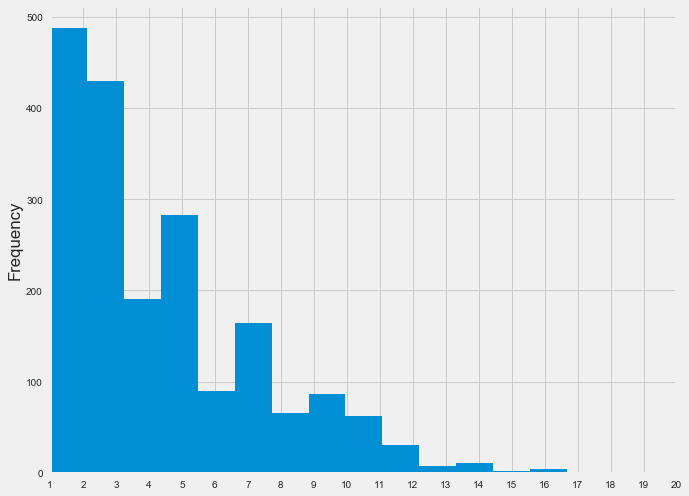

In [172]:
mma['scaled_tests'].plot.hist(figsize=(10,8), bins=20)
plt.xlim(1, 20)
plt.xticks(range(1,21))
plt.show()

In [151]:
mma['scaled_tests'].groupby(mma.year).agg(lambda x: np.percentile(x, q=100/3))

year
2015    1.983696
2016    2.000000
2017    3.000000
2018    2.339744
Name: scaled_tests, dtype: float64

In [63]:
rows = mma.shape[0]
for i in range(1,10):
    print('<={} tests: {}'.format(i, round(mma.loc[mma.tests<=i, :].shape[0]/rows, 2)))
    print('<={} required tests: {}\n'.format(i, round(mma.loc[mma.req_tests<=i, :]\
                                                      .shape[0]/rows, 2)))

<=1 tests: 0.24
<=1 required tests: 0.66

<=2 tests: 0.47
<=2 required tests: 0.77

<=3 tests: 0.66
<=3 required tests: 0.83

<=4 tests: 0.77
<=4 required tests: 0.87

<=5 tests: 0.83
<=5 required tests: 0.9

<=6 tests: 0.87
<=6 required tests: 0.93

<=7 tests: 0.9
<=7 required tests: 0.95

<=8 tests: 0.93
<=8 required tests: 0.96

<=9 tests: 0.95
<=9 required tests: 0.98



## Comparison w/ other sports

In [133]:
sports_means = sports['tests'].groupby(sports.sport).agg([np.mean, np.sum, len])\
    .sort_values('mean', ascending=False)
    
print(sports_means.head())
print(sports_means.tail())

                          mean   sum  len
sport                                    
Professional Boxing  11.134328   746   67
Speedskating          2.901408   618  213
Tennis                2.768293   227   82
Swimming              2.641509  1960  742
Biathlon              2.596154   135   52
                        mean  sum  len
sport                                 
Field Hockey        1.045045  116  111
Sailing             1.035088   59   57
Water Skiing        1.024390   42   41
Paralympic Fencing  1.000000    2    2
Paralympic Boccia   1.000000    9    9
